In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
from utils import *
from tf_utils import *
from model_graph import densenet
import keras
import tflearn
import pylab
os.environ["CUDA_VISIBLE_DEVICES"]='1'

/home/liy0f/.conda/envs/tf_1.0.1/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Help functions

In [2]:
def get_2_class(imgs, labs):
    label = np.concatenate(labs)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==2)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label
def plot_temp(feature, label):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()  

# Load data

In [3]:
# load cifar 10 data and choose two classes
train_data,test_data = keras.datasets.cifar10.load_data()
feature = train_data[0]
label = train_data[1]
feature, label = get_2_class(feature, label)

# Build model

In [4]:
inputs = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')
shortcut_flag = tf.placeholder(tf.bool, name='shortcut')

In [5]:
output, feature_transform = densenet(inputs, 2, 40, 12, 1.0,
                                     train_flag,shortcut_flag, input_shortcut)

In [6]:
#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))
step_adam = tf.train.AdamOptimizer(1e-4).minimize(cost)
step_momentum = tf.train.MomentumOptimizer(0.001, 0.9).minimize(cost)
step_gd = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [7]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training function

In [8]:
batch_size = 256
def optimize(optimizer_step, epochs):
    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()        
        for ii in range(len(label)//batch_size):
            index = np.random.choice(len(label), batch_size)
            dict_input = {inputs:feature[index], targets:label[index],
                          train_flag: True,
                          shortcut_flag: False,
                          input_shortcut: np.zeros([batch_size, 2])}
            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%50==0:
            saver.save(session,'../model/cifar10_binary_densenet{}.ckpt'.format(i))

# Train and check

In [9]:
# saver.restore(session, '../model/cifar10_binary_densenet400.ckpt')

In [10]:
all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-5)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost, var_list = last_layer_variables)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(tf.variables_initializer(last_layer_variables))
session.run(reset_opt_op)

In [11]:
optimize(step_momentum, 501)

('Epoche: 1/501', '| Training accuracy: ', 0.6171875, '| Cost: 0.672111093998', ' | Time for epoch: 34.57s')
('Epoche: 2/501', '| Training accuracy: ', 0.76953125, '| Cost: 0.540087342262', ' | Time for epoch: 30.74s')
('Epoche: 3/501', '| Training accuracy: ', 0.8125, '| Cost: 0.467748969793', ' | Time for epoch: 30.74s')
('Epoche: 4/501', '| Training accuracy: ', 0.8203125, '| Cost: 0.42850920558', ' | Time for epoch: 30.72s')
('Epoche: 5/501', '| Training accuracy: ', 0.875, '| Cost: 0.390554785728', ' | Time for epoch: 30.78s')
('Epoche: 6/501', '| Training accuracy: ', 0.80859375, '| Cost: 0.357126235962', ' | Time for epoch: 30.75s')
('Epoche: 7/501', '| Training accuracy: ', 0.78515625, '| Cost: 0.353274017572', ' | Time for epoch: 30.73s')
('Epoche: 8/501', '| Training accuracy: ', 0.8515625, '| Cost: 0.320698559284', ' | Time for epoch: 30.68s')
('Epoche: 9/501', '| Training accuracy: ', 0.86328125, '| Cost: 0.315896958113', ' | Time for epoch: 30.81s')
('Epoche: 10/501', '| T

('Epoche: 76/501', '| Training accuracy: ', 1.0, '| Cost: 0.00875346455723', ' | Time for epoch: 30.70s')
('Epoche: 77/501', '| Training accuracy: ', 1.0, '| Cost: 0.0122701833025', ' | Time for epoch: 30.81s')
('Epoche: 78/501', '| Training accuracy: ', 1.0, '| Cost: 0.010502374731', ' | Time for epoch: 30.79s')
('Epoche: 79/501', '| Training accuracy: ', 1.0, '| Cost: 0.00527022313327', ' | Time for epoch: 30.77s')
('Epoche: 80/501', '| Training accuracy: ', 1.0, '| Cost: 0.00620371475816', ' | Time for epoch: 30.71s')
('Epoche: 81/501', '| Training accuracy: ', 1.0, '| Cost: 0.00446500582621', ' | Time for epoch: 30.78s')
('Epoche: 82/501', '| Training accuracy: ', 1.0, '| Cost: 0.00393327698112', ' | Time for epoch: 30.82s')
('Epoche: 83/501', '| Training accuracy: ', 1.0, '| Cost: 0.00446379510686', ' | Time for epoch: 30.75s')
('Epoche: 84/501', '| Training accuracy: ', 1.0, '| Cost: 0.00490084616467', ' | Time for epoch: 30.75s')
('Epoche: 85/501', '| Training accuracy: ', 1.0, 

('Epoche: 153/501', '| Training accuracy: ', 1.0, '| Cost: 0.000362988124834', ' | Time for epoch: 30.71s')
('Epoche: 154/501', '| Training accuracy: ', 1.0, '| Cost: 0.000410826643929', ' | Time for epoch: 30.76s')
('Epoche: 155/501', '| Training accuracy: ', 1.0, '| Cost: 0.00035454632598', ' | Time for epoch: 30.70s')
('Epoche: 156/501', '| Training accuracy: ', 1.0, '| Cost: 0.000455609726487', ' | Time for epoch: 30.73s')
('Epoche: 157/501', '| Training accuracy: ', 1.0, '| Cost: 0.000443180440925', ' | Time for epoch: 30.74s')
('Epoche: 158/501', '| Training accuracy: ', 1.0, '| Cost: 0.00038387204404', ' | Time for epoch: 30.70s')
('Epoche: 159/501', '| Training accuracy: ', 1.0, '| Cost: 0.000321760075167', ' | Time for epoch: 30.74s')
('Epoche: 160/501', '| Training accuracy: ', 1.0, '| Cost: 0.000365414278349', ' | Time for epoch: 30.73s')
('Epoche: 161/501', '| Training accuracy: ', 1.0, '| Cost: 0.000353191629983', ' | Time for epoch: 30.72s')
('Epoche: 162/501', '| Trainin

('Epoche: 229/501', '| Training accuracy: ', 1.0, '| Cost: 0.000192600418814', ' | Time for epoch: 30.74s')
('Epoche: 230/501', '| Training accuracy: ', 1.0, '| Cost: 0.000191648927284', ' | Time for epoch: 30.75s')
('Epoche: 231/501', '| Training accuracy: ', 1.0, '| Cost: 0.000207827382837', ' | Time for epoch: 30.72s')
('Epoche: 232/501', '| Training accuracy: ', 1.0, '| Cost: 0.000193302650587', ' | Time for epoch: 30.74s')
('Epoche: 233/501', '| Training accuracy: ', 1.0, '| Cost: 0.000524317263626', ' | Time for epoch: 30.73s')
('Epoche: 234/501', '| Training accuracy: ', 1.0, '| Cost: 0.00028453746927', ' | Time for epoch: 30.73s')
('Epoche: 235/501', '| Training accuracy: ', 1.0, '| Cost: 0.000192125356989', ' | Time for epoch: 30.86s')
('Epoche: 236/501', '| Training accuracy: ', 1.0, '| Cost: 0.000200311391382', ' | Time for epoch: 30.87s')
('Epoche: 237/501', '| Training accuracy: ', 1.0, '| Cost: 0.000158239345183', ' | Time for epoch: 30.86s')
('Epoche: 238/501', '| Traini

('Epoche: 305/501', '| Training accuracy: ', 1.0, '| Cost: 0.000135644731927', ' | Time for epoch: 30.91s')
('Epoche: 306/501', '| Training accuracy: ', 1.0, '| Cost: 0.000106609833892', ' | Time for epoch: 30.90s')
('Epoche: 307/501', '| Training accuracy: ', 1.0, '| Cost: 0.000108052496216', ' | Time for epoch: 30.90s')
('Epoche: 308/501', '| Training accuracy: ', 1.0, '| Cost: 0.000130233485834', ' | Time for epoch: 30.85s')
('Epoche: 309/501', '| Training accuracy: ', 1.0, '| Cost: 9.97778115561e-05', ' | Time for epoch: 30.86s')
('Epoche: 310/501', '| Training accuracy: ', 1.0, '| Cost: 0.00015175784938', ' | Time for epoch: 30.89s')
('Epoche: 311/501', '| Training accuracy: ', 1.0, '| Cost: 0.000112939975224', ' | Time for epoch: 30.89s')
('Epoche: 312/501', '| Training accuracy: ', 1.0, '| Cost: 0.000112570436613', ' | Time for epoch: 30.85s')
('Epoche: 313/501', '| Training accuracy: ', 1.0, '| Cost: 0.000148381222971', ' | Time for epoch: 30.86s')
('Epoche: 314/501', '| Traini

('Epoche: 381/501', '| Training accuracy: ', 1.0, '| Cost: 0.000633981486317', ' | Time for epoch: 30.88s')
('Epoche: 382/501', '| Training accuracy: ', 1.0, '| Cost: 0.000559796055313', ' | Time for epoch: 30.84s')
('Epoche: 383/501', '| Training accuracy: ', 1.0, '| Cost: 0.000510320765898', ' | Time for epoch: 30.90s')
('Epoche: 384/501', '| Training accuracy: ', 1.0, '| Cost: 0.000461507588625', ' | Time for epoch: 30.87s')
('Epoche: 385/501', '| Training accuracy: ', 1.0, '| Cost: 0.000453566230135', ' | Time for epoch: 30.87s')
('Epoche: 386/501', '| Training accuracy: ', 1.0, '| Cost: 0.00046737655066', ' | Time for epoch: 30.87s')
('Epoche: 387/501', '| Training accuracy: ', 1.0, '| Cost: 0.000586884503718', ' | Time for epoch: 30.91s')
('Epoche: 388/501', '| Training accuracy: ', 1.0, '| Cost: 0.000475388747873', ' | Time for epoch: 30.87s')
('Epoche: 389/501', '| Training accuracy: ', 1.0, '| Cost: 0.000344309664797', ' | Time for epoch: 30.89s')
('Epoche: 390/501', '| Traini

('Epoche: 457/501', '| Training accuracy: ', 1.0, '| Cost: 0.000146339152707', ' | Time for epoch: 30.88s')
('Epoche: 458/501', '| Training accuracy: ', 1.0, '| Cost: 0.000155309448019', ' | Time for epoch: 30.90s')
('Epoche: 459/501', '| Training accuracy: ', 1.0, '| Cost: 0.00015112379333', ' | Time for epoch: 30.86s')
('Epoche: 460/501', '| Training accuracy: ', 1.0, '| Cost: 0.000145989732118', ' | Time for epoch: 30.87s')
('Epoche: 461/501', '| Training accuracy: ', 1.0, '| Cost: 0.000134637084557', ' | Time for epoch: 30.87s')
('Epoche: 462/501', '| Training accuracy: ', 1.0, '| Cost: 0.000146218735608', ' | Time for epoch: 30.82s')
('Epoche: 463/501', '| Training accuracy: ', 1.0, '| Cost: 0.00018538403674', ' | Time for epoch: 30.85s')
('Epoche: 464/501', '| Training accuracy: ', 1.0, '| Cost: 0.000155623158207', ' | Time for epoch: 30.87s')
('Epoche: 465/501', '| Training accuracy: ', 1.0, '| Cost: 0.000135791909997', ' | Time for epoch: 30.90s')
('Epoche: 466/501', '| Trainin

In [12]:
# check test data performance
feature_test = test_data[0]
label_test = test_data[1]
feature_test, label_test = get_2_class(feature_test, label_test)
test_acc = []  

image_obj = batch_object(feature_test, batch_size)
label_obj = batch_object(label_test, batch_size)
for ii in range(len(label)//batch_size):
    imgs = image_obj.next_batch()
    labs = label_obj.next_batch()
    test_acc.append(
        session.run(accuracy, 
                    feed_dict={inputs:imgs, targets:labs,
                               train_flag: False,
                               shortcut_flag: False,
                               input_shortcut: np.zeros([batch_size, 2])}))

print("Test accuracy: {}".format(np.mean(test_acc)))


Test accuracy: 0.925480782986


In [13]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [14]:
batch_size_test = 256
# def get_transform_feature():
feature_t = []
label_t = []
image_obj = batch_object(feature, batch_size_test)
label_obj = batch_object(label, batch_size_test)
for ii in range(len(label)//batch_size_test):
    imgs = image_obj.next_batch()
    labs = label_obj.next_batch()
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs,
                               train_flag: False,
                               shortcut_flag: False,
                               input_shortcut: np.zeros([batch_size, 2])}))

label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)

feature_t = np.concatenate(feature_t, 0)

In [15]:
feature_t.shape

(9984, 2)

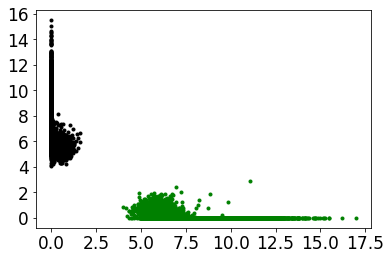

In [16]:
plot_temp(feature_t, label_t)

In [18]:
feature_random, label_random = random_points(-1,
    20,-2, 20, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:np.zeros([100,32,32,3]), 
               targets:label_random,
               train_flag: False, 
               shortcut_flag: True,
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

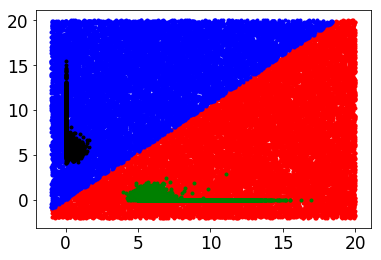

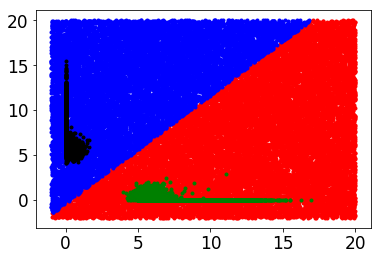

In [19]:
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

In [46]:
	plot_blobs_all_together(feature_random, pre_label_nn,feature_t, label_t,
		'../result/exploration/NN_transform_cifar10_densenet.png')
	plot_blobs_all_together(feature_random, pre_label_svm,feature_t, label_t,
		'../result/exploration/SVM_transform_cifar10_densenet.png')